In [1]:
import sys 
sys.path.append(r'../../Development/utility')
sys.path.append(r'../../Development/Network/Python Script/model')
import tensorflow as tf 
import numpy as np 
import cv2
import os
import random as r
#import loadpointmap as lp
import img_processor as ip
import antipodal_sampler as ap 
import pose_estimator as pe 
import json

In [2]:
im_dir = r'C:\Users\Adam\Documents\Deep Learning-Based Grasp Detection\Development\Network\Point Map Data\hv8\pointmap0.txt'

In [3]:
#parameters
with open(r'../../Development/Simulation/source code/JSON File/parameters.json') as f:
    parameters = json.load(f)

In [4]:
data_size = parameters['hv8'][4:6]
grasp_range = parameters['hv8'][0:2]
img_size = [1024,1280]
roi = [230,730,200,970]

In [5]:
from model import Discriminator, MaskPredictor, GraspNet

#building and loading  model's weight
weight_dir0 = r'../Weights/Discriminator_hv8'
weight_dir1 = r'../Weights/MaskPredictor_hv8'

D = Discriminator()
D.build((1,data_size[0],data_size[1],3))
D.load_weights(weight_dir0)

M = MaskPredictor()
M.build((1,data_size[0],data_size[1],3))
M.load_weights(weight_dir1)

model = GraspNet()
model.build((1,data_size[0],data_size[1],3))

#combining weights
for i in range(11):
    weight = D.layers[i].get_weights()
    model.layers[i].set_weights(weight)

for i in range(11,20):
    weight = M.layers[i-4].get_weights()
    model.layers[i].set_weights(weight)

In [6]:
depth = ip.pointmaptodepth(im_dir,'txt', img_size, roi)

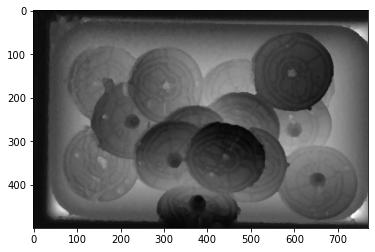

In [7]:
import matplotlib.pyplot as plt
plt.imshow(depth,cmap='gray')

In [8]:
#computing edge image
blur = cv2.GaussianBlur(depth, (7,7), 0)
edgeImg = cv2.Canny(blur, 5, 60)

#grasps sampling
normals, edgepx = ap.normals(depth, edgeImg)
grasps, normals = ap.line_antipodal_sampler(edgepx, normals, grasp_range)

In [9]:
#generating grasp image representations
data, r_matrix = ip.data_generator(grasps, depth, data_size)
data = np.array(data, dtype='float32') / 255.

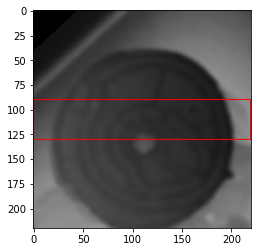

In [10]:
plt.imshow(data[0])

In [11]:
scores_list = []
masks_list = []
confidence = []

@tf.function
def inference(image):
    score, mask = model(image)
    return score, mask

In [14]:
#inference
i = 0
scores_list.clear()
masks_list.clear()

#calculate time
import time
time_start = time.time()

bs = 2 
it = data.shape[0] // bs
for i in range(it):
    image = data[i*bs:(i+1)*bs]
    tf.print('Inference Step: ', i)
    score, mask = inference(image)
    #scores_list.append(score.numpy()[0])
    #masks_list.append(mask.numpy()[0,:,:,0])

#calculate time
time_elapsed = (time.time() - time_start)

#scores = np.vstack(scores_list)
#masks = np.array(masks_list)


Inference Step:  0
Inference Step:  1
Inference Step:  2
Inference Step:  3
Inference Step:  4
Inference Step:  5
Inference Step:  6
Inference Step:  7
Inference Step:  8
Inference Step:  9
Inference Step:  10
Inference Step:  11
Inference Step:  12
Inference Step:  13
Inference Step:  14
Inference Step:  15
Inference Step:  16
Inference Step:  17
Inference Step:  18
Inference Step:  19
Inference Step:  20
Inference Step:  21
Inference Step:  22
Inference Step:  23
Inference Step:  24
Inference Step:  25
Inference Step:  26
Inference Step:  27
Inference Step:  28
Inference Step:  29
Inference Step:  30
Inference Step:  31
Inference Step:  32
Inference Step:  33
Inference Step:  34
Inference Step:  35
Inference Step:  36
Inference Step:  37
Inference Step:  38
Inference Step:  39


In [15]:
time_elapsed

3.690880537033081